In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from utilsTopology import *
from utilsBaricentricNeuralNetwork import *

2024-12-26 10:40:48.274523: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735206049.533161    4144 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735206049.872022    4144 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 10:40:52.544231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Example of a CPLF generated by two point. In this case is a simple continuous linear function.

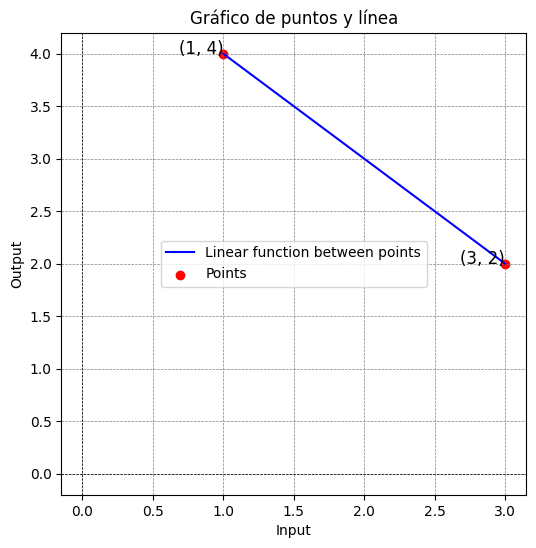

In [7]:
x1, y1 = 1, 4
x2, y2 = 3, 2

plt.figure(figsize=(6, 6))
plt.plot([x1, x2], [y1, y2], 'b-', label="Linear function between points")  
plt.scatter([x1, x2], [y1, y2], color='red', label="Points")    

plt.text(x1, y1, f"({x1}, {y1})", fontsize=12, ha='right')
plt.text(x2, y2, f"({x2}, {y2})", fontsize=12, ha='right')

plt.title("Gráfico de puntos y línea")
plt.xlabel("Input")
plt.ylabel("Output")
plt.axhline(0, color='black',linewidth=0.5, linestyle="--")  
plt.axvline(0, color='black',linewidth=0.5, linestyle="--")  
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend()
plt.show()

In the following code we can see that this method does not work for a typical neural network, with layers of connected neurons. 

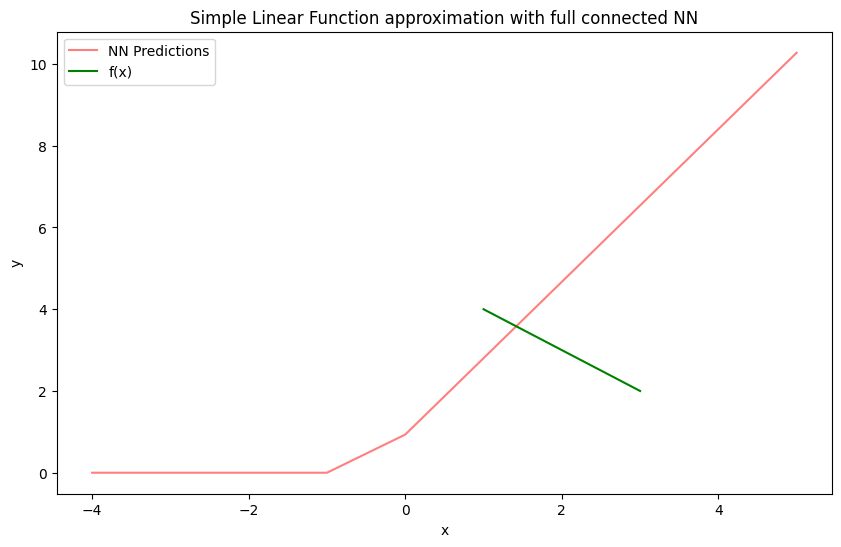

In [13]:
class SimplePiecewiseLinearNN(nn.Module):
    def __init__(self):
        super(SimplePiecewiseLinearNN, self).__init__()
        self.hidden_layer = nn.Linear(1, 2, bias=True)
        self.output_layer = nn.Linear(2, 1, bias=False)
        self.initialize_weights()

    def initialize_weights(self):
        self.hidden_layer.weight.data[0, 0] = 1 # m1
        self.hidden_layer.bias.data[0] = x1/(x2-x1)
        
        self.hidden_layer.weight.data[1, 0] = 1 # m1
        self.hidden_layer.bias.data[1] = x1/(x2-x1)
        
        self.output_layer.weight.data[0,1] = y1
        self.output_layer.weight.data[0,1] = y2
    
    def print_weights(self):
        print("Hidden layer weights:")
        print(self.hidden_layer.weight.data)
        print("Bias of the hidden layer:")
        print(self.hidden_layer.bias.data)
        print("Output layer weights:")
        print(self.output_layer.weight.data)

    def forward(self, x):
        hidden_output = self.hidden_layer(x)
        hidden_output = torch.relu(hidden_output)
        output = self.output_layer(hidden_output)
        return output
        
model = SimplePiecewiseLinearNN()


x_train = np.linspace(x1-5,x2+2,10)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
    y_test = model(x_train_tensor).numpy()
    
plt.figure(figsize=(10, 6))
plt.plot(x_train, y_test, 'r-', label="NN Predictions", alpha=0.5)
plt.plot([x1, x2], [y1, y2], 'g-', label="f(x)") 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simple Linear Function approximation with full connected NN')
plt.legend()
plt.show()

We actually have to simulate a layer that simulates the defined mathematical formula:

$f(x) = step(t) \cdot ReLU(1 - t) \cdot y_i + step(1-t) \cdot ReLU(t) \cdot y_{i+1}$.

where \( t \) is the barycentric coordinate, defined as:

$t = \frac{x - x_i}{x_{i+1} - x_i}$$.

## Theorem 1: Linear function

### Increasing linear function

$f(x) = m*x + n$, con m = 1 y n = 1, en $x \in [1,3]$

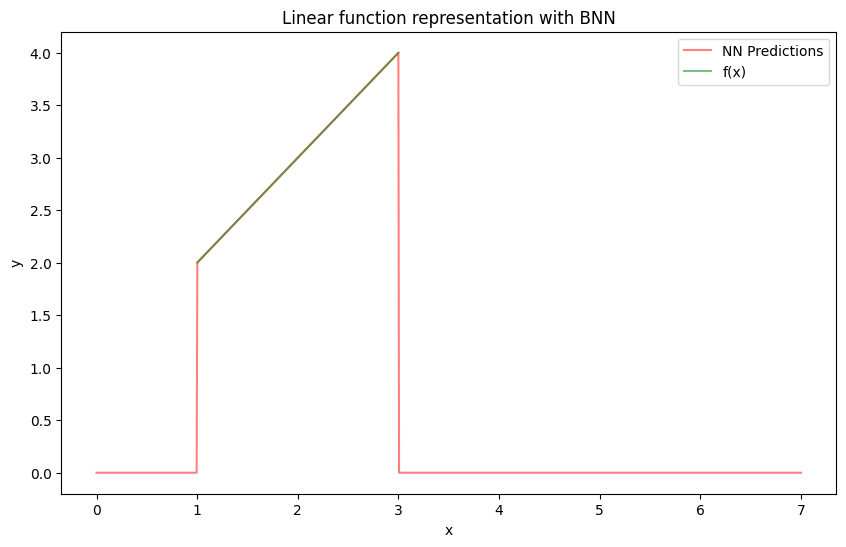

In [15]:
points = [[1,2],[3,4]]
xs = [point[0] for point in points]
ys = [point[1] for point in points]

# Create the network
network = BaricentricNetwork(points)

# Generate test input for t using barycentric coordinates between the points
# t = (x - x1) / (x2 - x1)
x_values = torch.linspace(0, 7, steps=1000)
outputs = network(x_values)
x_values, outputs

plt.figure(figsize=(10, 6))
plt.plot(x_values, outputs, 'r-', label='NN Predictions', alpha=0.5)
plt.plot(xs, ys, 'g-', label="f(x)", alpha=0.5) 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear function representation with BNN')
plt.legend()
plt.show()


## Decreasing linear function

$f(x) = m*x + n$, con m = -1 y n = 5, en $x \in [1,3]$

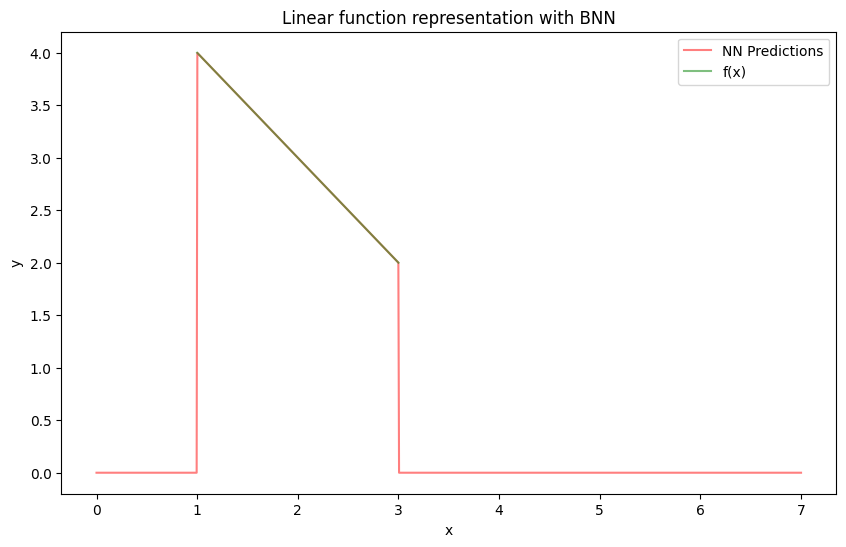

In [16]:
points = [[1,4],[3,2]]
xs = [point[0] for point in points]
ys = [point[1] for point in points]

# Create the network
network = BaricentricNetwork(points)

# Generate test input for t using barycentric coordinates between the points
# t = (x - x1) / (x2 - x1)
x_values = torch.linspace(0, 7, steps=1000)
outputs = network(x_values)
x_values, outputs

plt.figure(figsize=(10, 6))
plt.plot(x_values, outputs, 'r-', label='NN Predictions', alpha=0.5)
plt.plot(xs, ys, 'g-', label="f(x)", alpha=0.5) 
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear function representation with BNN')
plt.legend()
plt.show()


### CPLF function formed by two increasing linear functions

$f_1(x) = m_1*x + n_1$, with m = 1 and n = 1, in $x \in [1,3]$

$f_2(x) = m_2*x + n_2$, with m = 2 and n = -2, in $x \in [3,5]$

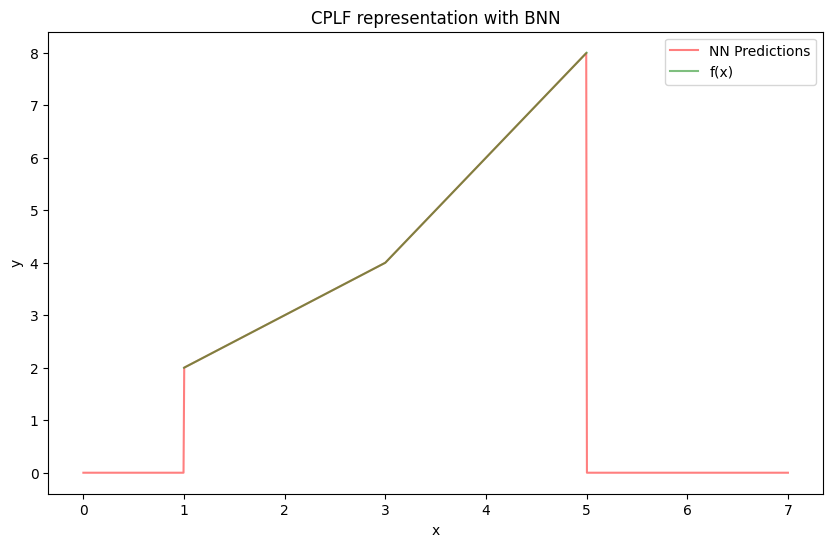

In [18]:
points = [[1,2],[3,4],[5,8]]
xs = [point[0] for point in points]
ys = [point[1] for point in points]

# Create the network
network = BaricentricNetwork(points)

# Generate test input for t using barycentric coordinates between the points
# t = (x - x1) / (x2 - x1)
x_values = torch.linspace(0, 7, steps=1000)
outputs = network(x_values)
x_values, outputs

plt.figure(figsize=(10, 6))
plt.plot(x_values, outputs, 'r-', label='NN Predictions', alpha=0.5)
plt.plot(xs, ys, 'g-', label="f(x)", alpha=0.5) 
plt.xlabel('x')
plt.ylabel('y')
plt.title('CPLF representation with BNN')
plt.legend()
plt.show()


### CPLF function formed by a decreasing and an increasing function, in that order.
$f_1(x) = m_1*x + n_1$, with m = -1 and n = 5, in $x [1,3]$

$f_2(x) = m_2*x + n_2$, with m = 2 and n = -4, in $x \in [3,5]$

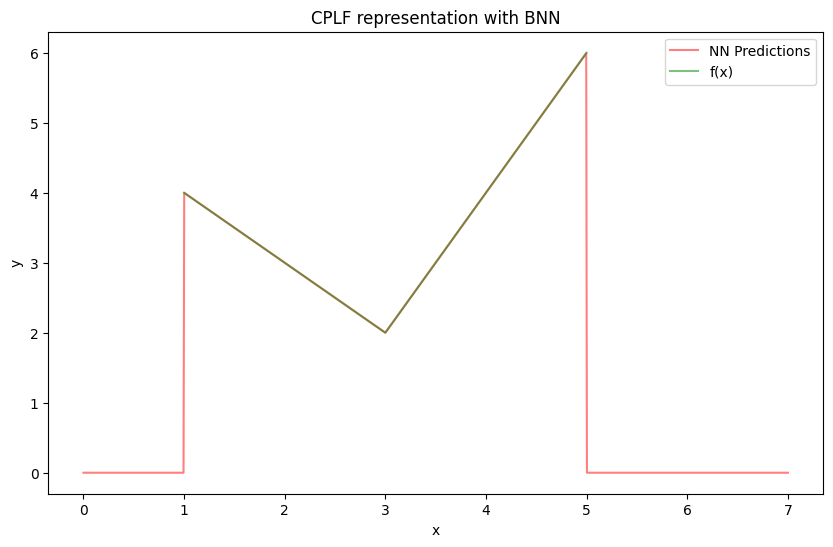

In [19]:
points = [[1,4],[3,2],[5,6]]
xs = [point[0] for point in points]
ys = [point[1] for point in points]

# Create the network
network = BaricentricNetwork(points)

# Generate test input for t using barycentric coordinates between the points
# t = (x - x1) / (x2 - x1)
x_values = torch.linspace(0, 7, steps=1000)
outputs = network(x_values)
x_values, outputs

plt.figure(figsize=(10, 6))
plt.plot(x_values, outputs, 'r-', label='NN Predictions', alpha=0.5)
plt.plot(xs, ys, 'g-', label="f(x)", alpha=0.5) 
plt.xlabel('x')
plt.ylabel('y')
plt.title('CPLF representation with BNN')
plt.legend()
plt.show()

## Theorem 2: CPLF

If we have a continuous piecewise linear function, we can represent it by tis barycentric neural network:

### Example 1
$
$f(x)$ = \begin{cases} 
    x + 2 & \text{if } x \in [-10,0)\\
    -x + 2 & \text{if } x \in [0, 2)\\
    x - 2 & \text{if } x >= [2,10)
\end{cases}
$

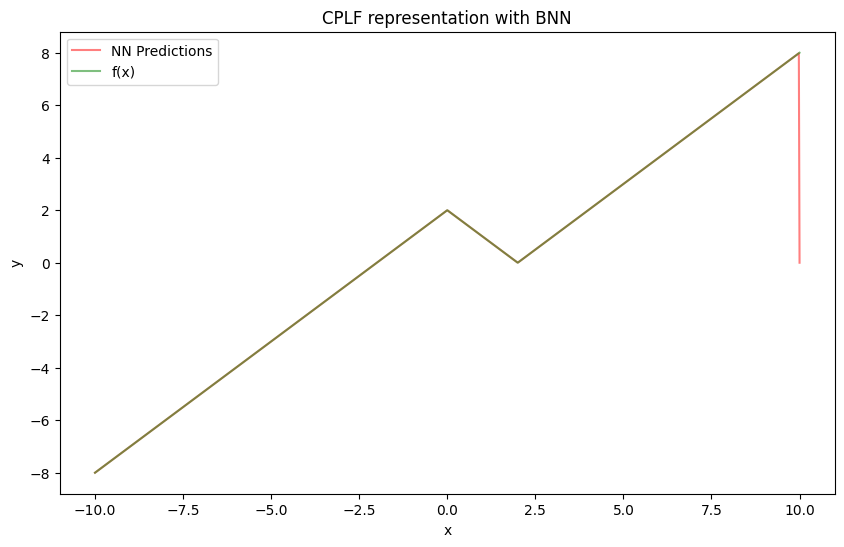

In [25]:
points = [(-10, -8), (0, 2), (2, 0), (10, 8)]
xs = [point[0] for point in points]
ys = [point[1] for point in points]

# Create the network
network = BaricentricNetwork(points)

# Generate test input for t using barycentric coordinates between the points
# t = (x - x1) / (x2 - x1)
x_values = torch.linspace(-10, 10, steps=1000)
outputs = network(x_values)
x_values, outputs

plt.figure(figsize=(10, 6))
plt.plot(x_values, outputs, 'r-', label='NN Predictions', alpha=0.5)
plt.plot(xs, ys, 'g-', label="f(x)", alpha=0.5) 
plt.xlabel('x')
plt.ylabel('y')
plt.title('CPLF representation with BNN')
plt.legend()
plt.show()

### Example 2

$
$f(x)$=
\begin{cases} 
    3x + 1 & \text{si } x \in [-10, -2) \\
    2x - 1 & \text{si } x \in [-2, 1) \\
    x & \text{si } x \in [1, 4) \\
    -0.5x + 4 & \text{si } x \in [4,10) 
\end{cases}
$

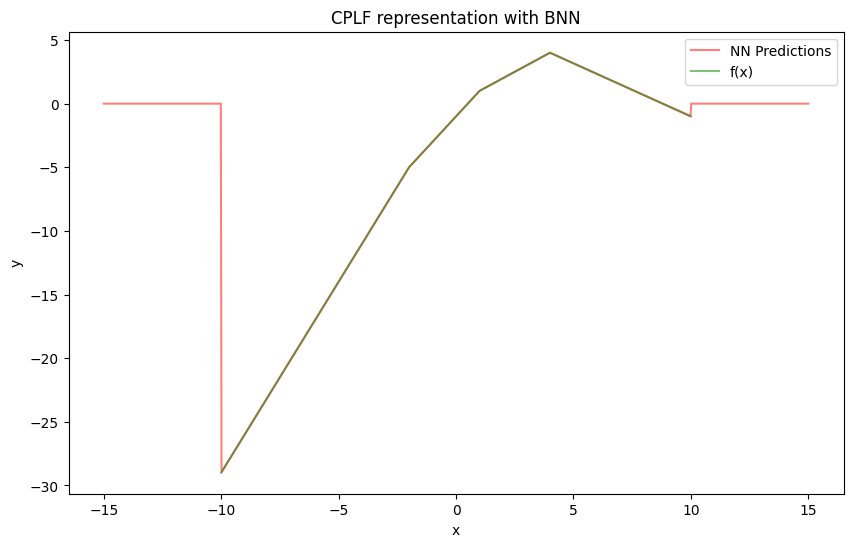

In [26]:
# Definir una lista de puntos [(x1, y1), (x2, y2), ..., (xn, yn)]
points = [(-10, -29), (-2, -5), (1, 1), (4, 4), (10, -1)]
xs = [point[0] for point in points]
ys = [point[1] for point in points]

# Create the network
network = BaricentricNetwork(points)

# Generate test input for t using barycentric coordinates between the points
# t = (x - x1) / (x2 - x1)
x_values = torch.linspace(-15, 15, steps=1000)
outputs = network(x_values)
x_values, outputs

plt.figure(figsize=(10, 6))
plt.plot(x_values, outputs, 'r-', label='NN Predictions', alpha=0.5)
plt.plot(xs, ys, 'g-', label="f(x)", alpha=0.5) 
plt.xlabel('x')
plt.ylabel('y')
plt.title('CPLF representation with BNN')
plt.legend()
plt.show()

## Example 3

Any points directly form a CPLF, it is simpler that way.

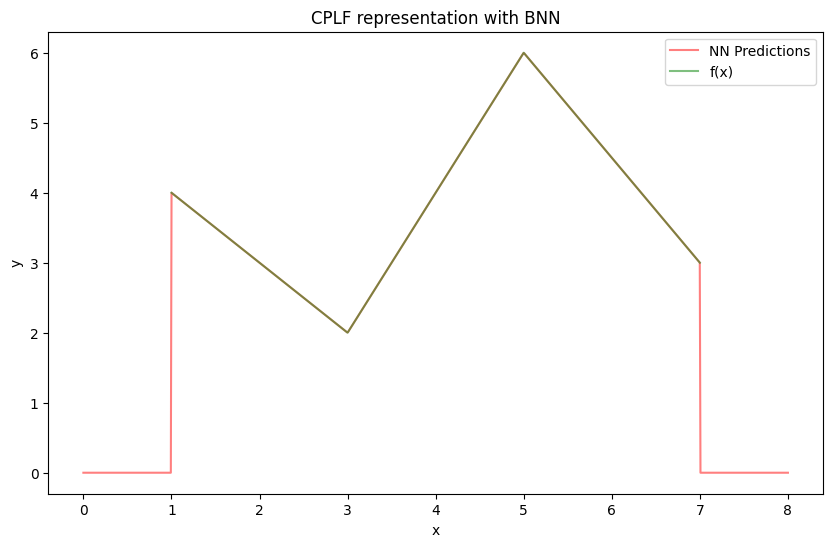

In [27]:
points = [(1, 4), (3, 2), (5, 6), (7, 3)]
xs = [point[0] for point in points]
ys = [point[1] for point in points]

# Create the network
network = BaricentricNetwork(points)

# Generate test input for t using barycentric coordinates between the points
# t = (x - x1) / (x2 - x1)
x_values = torch.linspace(0, 8, steps=1000)
outputs = network(x_values)
x_values, outputs

plt.figure(figsize=(10, 6))
plt.plot(x_values, outputs, 'r-', label='NN Predictions', alpha=0.5)
plt.plot(xs, ys, 'g-', label="f(x)", alpha=0.5) 
plt.xlabel('x')
plt.ylabel('y')
plt.title('CPLF representation with BNN')
plt.legend()
plt.show()